Unless denoted otherwise, all functions and code were created by Pepijn van den Berg.

In [1]:
import scipy.io
import io
from data_loader import DataLoader
import numpy as np
from utils import *
from matplotlib import pyplot as plt
import numpy.random as rng

In [2]:
def load_data(rats):
    return DataLoader('C:\\Users\\pepij\\OneDrive\\Documenten\\02 AI\\4 Thesis\\GG-Dataset-Tulio-Ultralight\\' , 'BLA', rats=[rats])

In [3]:
def session_vars(session_nr):
    """
    This function finds the following session-specific variables:
        neuron_list: a list of all neuron numbers
        n_neurons:   the total number of neurons
        session:     the session code
        begin_run_t: at what time the run-component of the session starts
        end_run_t:   at what time the run-component of the session ends        
    """
    session = list(data.events[rat].keys())[session_nr]
    neuron_list = list(spk[rat][session][area].keys())
    n_neurons = len(neuron_list)

    begin_run_i = list(data.events[rat][session]['cat']['data']).index('beginning run')
    end_run_i = list(data.events[rat][session]['cat']['data']).index('end run')

    begin_run_t = list(data.events[rat][session]['cat']['ts'])[begin_run_i]
    end_run_t = list(data.events[rat][session]['cat']['ts'])[end_run_i]
    
    return neuron_list, n_neurons, session, begin_run_t, end_run_t

In [4]:
def position_vars(visualization=False):
    """"
    This function finds two variables related to position of the rat:
        x:        the x coordinate of the rat
        y:        the y coordinate of the rat
        time_loc: the series of locations with their corresponding times
        x_mean:   the mean x-coordinate of the rat during a puff
        puff_locs_x: used for visualization. x locations of puffs
        puff_locs_y: used for visualization. y locations of puffs
    """
    x = data.position[rat][session]['x']
    y = data.position[rat][session]['y']
    time_loc = data.position[rat][session]['Time']

    # Cut x and y to the run session. 
    loc_run_ind = [index for index, t in enumerate(time_loc) if t > begin_run_t and t < end_run_t]
    
    x_cut = x[loc_run_ind[0]:loc_run_ind[-1]]
    y_cut = y[loc_run_ind[0]:loc_run_ind[-1]]
    
    # Find the puff events and location
    puff_events_ = data.events[rat][session]['puf']['ts']
    puff_events = []
    
    # Make sure the puff events are an int format (some sessions consist of strings)
    if isinstance(list(puff_events_)[0], str):
        for t in np.array(puff_events_):
            puff_events.append(float(t[:14]))
    else:
        puff_events = puff_events_
    
    
    # Filter puff events to run session
    puff_events = [t for t in puff_events if t > begin_run_t and t < end_run_t]
    
    
    puff_locs_x = [x_cut[np.absolute(time_loc-i).argmin()] for i in puff_events]
    puff_locs_y = [y_cut[np.absolute(time_loc-i).argmin()] for i in puff_events]

    # Find the mean of the puff location
    x_mean = np.mean(puff_locs_x)

    if(visualization):
        plt.figure(figsize = (12,12))
        plt.subplot(2, 2, 1)
        plt.plot(x_cut,y_cut)
        plt.plot(puff_locs_x, puff_locs_y, 'o', label = 'puff locations')
        ylimits = plt.ylim()
        plt.vlines(x = x_mean, ymin=ylimits[0], ymax= ylimits[1],linestyle='--', color='black', label = 'mean puff location')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(x_cut, time_loc[loc_run_ind[0]:loc_run_ind[-1]])
        plt.plot(puff_locs_x, puff_events, 'o', label = 'puff locations')
        
        plt.subplot(2, 2, 3)
        plt.hist(puff_locs_x, density=True)
        ylim = plt.ylim()
        plt.vlines(x_mean,ymin=0, ymax=ylim[1],color='red', label = 'mean')
        plt.legend()        
        plt.show()
    
    return x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut

In [5]:
def spike_matrix_init(window, bin_width, visualization = False):
    """
    This function constructs a spike matrix of shape [trial x neuron x bin]. 
    Every trial consists of an airpuff event, or the crossing of the location of an airpuff event.
    Together with the matrix, a vector is returned that labels each trial as a puff/safe trial.
    """
    # Find all reward timings of the session
    lrw_ts_ = list(data.events[rat][session]['lrw']['ts']) 
    rrw_ts_ = list(data.events[rat][session]['rrw']['ts']) 
    
    lrw_ts = []
    rrw_ts = []
    
    # Make sure the rewards are an int format (some sessions consist of strings)
    if isinstance(rrw_ts_[0], str):
        for t in np.array(rrw_ts_):
            rrw_ts.append(float(t[:14]))
    else:
        rrw_ts = rrw_ts_
    
    if isinstance(lrw_ts_[0], str):
        for t in np.array(lrw_ts_):
            lrw_ts.append(float(t[:14]))
    else:
        lrw_ts = lrw_ts_

    # Cut off the left- and right rewards to the run-session
    rrw_ts = [t for t in rrw_ts if t > begin_run_t and t < end_run_t]
    lrw_ts = [t for t in lrw_ts if t > begin_run_t and t < end_run_t]

    # Concatenate all reward timings
    rw_ts = np.sort(rrw_ts + lrw_ts)

    # Create bins 
    bins = np.arange(window[0],window[1]+1,bin_width)

    # Initialize the spike matrix
    spk_matrix_ = np.zeros([len(rw_ts)-1,n_neurons,bins.shape[0]-1]) # dimensions: trial x neuron x bins

    # Initialize the trial type vector
    trial_type = np.ndarray(len(rw_ts)-1)

    # Keep track of event locations, only used for visualization
    nopuff_x = []
    nopuff_y = []
    puff_x = []
    puff_y = []
    
    # Keep track of the most recent puff
    last_puff_x = x_mean 
    
    # Keep track of all event times (only for visualization)
    event_ts_puff = []
    event_ts_safe = []
    
    for reward_i, reward_t in enumerate(rw_ts[:-1]):  # Every reward except the last marks the start of a run
        # Make a list of puffs in the trial, if any
        puff_list = [t for t in data.events[rat][session]['puf']['ts'] if t > reward_t and t < rw_ts[reward_i+1]]

        valid_trial = True
        
        # Check whether this is a puff trial
        if np.any(puff_list):
            event_t = puff_list[-1]
            event_ts_puff.append(event_t)
            
            # update last puff variable
            last_puff_x = x[np.absolute(time_loc-event_t).argmin()]
            puff_x.append(last_puff_x)
            puff_y.append(y[np.absolute(time_loc-event_t).argmin()])

        else: # If in a no-puff trial:
            # Take a time slice of the trial 
            time_loc_ind = [index for index, t in enumerate(time_loc) if t > reward_t and t < rw_ts[reward_i+1]]
            
            # Check whether the timepoints give an empty array 
            if(~np.any(np.array(time_loc_ind))):
                valid_trial = False
                continue
            
            # Cut x, y and t to the trial
            x_trial = list(x[time_loc_ind[0]:time_loc_ind[-1]])
            y_trial = list(y[time_loc_ind[0]:time_loc_ind[-1]])
            time_loc_trial = list(time_loc)[time_loc_ind[0]:time_loc_ind[-1]]           
            
            # Find the t where the rat is the closest to the recent puff location
            if len(np.array(x_trial))==0: # Some sessions have missing location data. This prevents an error
                   event_t = 0
            else:
                event_t = time_loc_trial[np.absolute(np.array(x_trial)-last_puff_x).argmin()]
            event_ts_safe.append(event_t)
            
            if(visualization):
                nopuff_x.append(x_trial[np.absolute(np.array(x_trial)-last_puff_x).argmin()]) 
                nopuff_y.append(y_trial[np.absolute(np.array(x_trial)-last_puff_x).argmin()]) 
        
        if(valid_trial):
            for ineuron in range(n_neurons):
                spikes = spk[rat][session][area][neuron_list[ineuron]]
                idx = np.where(np.logical_and(spikes>event_t+window[0], spikes<event_t+window[1]))[0]
                count = np.histogram(spikes[idx]-event_t,bins)
                spk_matrix_[reward_i,ineuron] = count[0]
        else:
            spk_matrix_[reward_i,ineuron] = np.zeros(len(range(window[0], window[1]+1)))
                

        # Put a 1 if in a puff trial, and a 0 otherwise
        trial_type[reward_i] = int(np.any(puff_list))

    if(visualization):   
        plt.figure(figsize = (10,5))
        plt.plot(x_cut, y_cut)
        plt.plot(puff_x, puff_y, 'o', markersize=3, color='r', label = 'puff locations')
        plt.plot(nopuff_x, nopuff_y, 'o', markersize=3, color='lime', label = 'non-puff locations')
        ylimits = plt.ylim()
        plt.vlines(x = x_mean, ymin=ylimits[0], ymax= ylimits[1],linestyle='--', color='black', label = 'mean puff location')
        plt.legend()
        plt.savefig('Figure8a.svg')
        plt.savefig('Figure8a.jpg')
        plt.show()
        #plt.figure()
        #plt.title('All spikes in the session, timelocked at puff/no puff')
        #plt.imshow(np.sum(spk_matrix_,axis=0),aspect='auto',cmap='gray_r', vmin=0, vmax=1)
        #plt.xticks(range(0, spk_matrix_.shape[2], 200), range(window[0],window[1], 200))
        #plt.xlabel('Time (ms)')
        #plt.ylabel('Neuron')
        #plt.vlines(x = window[1], ymin=0, ymax= spk_matrix_.shape[1],linestyle='--', color='black', alpha=0.5)
        
        plt.show()
        
        plt.figure(figsize = (10,10))
        plt.plot(x, time_loc)
        plt.plot(puff_x, event_ts_puff, 'o', color='r',label='Puff events')
        plt.plot(nopuff_x, event_ts_safe, 'o', color='lime', label='Safe events')
        plt.ylim([10250000, 10900000])
        plt.xlabel('x')
        plt.ylabel('time (ms)')
        plt.savefig('Figure8b.svg')
        plt.savefig('Figure8b.jpg')
        plt.show()

    return spk_matrix_, trial_type

In [6]:
def mask_spikes(puff = True):
    """
    This function returns the spike matrix for only the trials that are puff (or no puff if puff = False)
    """
    PUFF = 1
    SAFE = 0

    puff_idx = np.where(trial_type == PUFF)[0]
    safe_idx = np.where(trial_type == SAFE)[0]
   
    if puff:
        return spk_matrix_[puff_idx,:,:]
    else:
        return spk_matrix_[safe_idx,:,:]

In [7]:
def firing_ranks_spkmatrix(spikes_slice):
    """
    Compute the ranks (i.e., the order in which the neurons spiked) of the given data
    """
    
    # Make a vector for average spike times per neuron
    avg_spike = np.zeros([spikes_slice.shape[1]])
    
    # Make a matrix of ranks for each trial
    ranks = np.full([spikes_slice.shape[0], spikes_slice.shape[1]], np.nan)

    for trial in range(spikes_slice.shape[0]):    
        # Find average spiking time per neuron
        for ineuron in range(spikes_slice.shape[1]):
            avg_spike[ineuron] = np.mean([bin_idx for bin_idx, activity in enumerate(spikes_slice[trial, ineuron]) if activity > 0])
        
        # Sort the neurons, based on their avg spiking time
        sorted_neurons = np.argsort(avg_spike)

        # Fill the rank matrix, but only for the defined 'rank-slots'
        for ineuron, neuron in enumerate(sorted_neurons):
            if not np.isnan(avg_spike[neuron]):
                ranks[trial,ineuron] = neuron 
    return ranks

In [8]:
def event_locked_seq(win, n_surrogates, visualization = False):
    """
    Returns the URI, p-value and occ-matrix when timelocked to the stimulus
    """
    URI, URI_p_val, occurrence_matrix = getURI(spk_matrix[:,:,window[1]:window[1]+win], n_surrogates)

    sorted_occ = sort_occ_matrix(occurrence_matrix, mean_rank=True)
    if len(sorted_occ[2]) < 5:
        URI_p_val = np.nan
    
    if visualization:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title('Sorted on mean rank')
        
        plt.imshow(sorted_occ[0])
        plt.yticks(range(len(sorted_occ[2])), sorted_occ[2][sorted_occ[1]])
        print(sorted_occ[2])
        plt.colorbar()
        
        plt.subplot(1, 2, 2)
        plt.title('Sorted on most frequent rank')
        sorted_occ = sort_occ_matrix(occurrence_matrix)
        plt.imshow(sorted_occ[0])
        plt.yticks(range(len(sorted_occ[2])), sorted_occ[2][sorted_occ[1]])        
        plt.colorbar()
        
        plt.savefig('Event-locked-sequence.svg')
        plt.show()
        
    return URI, URI_p_val, occurrence_matrix

In [9]:
def sort_occ_matrix(occ_matrix, mean_rank=False):   
    """"
    Modifies an occ matrix to only active neurons and 'used' rank positions. 
    Also, it sorts the matrix, either based on mean rank, or on mode rank.
    """
    # Find active neurons
    active_neurons = np.where(np.any(occ_matrix!=0, axis=1))[0]

    # Find non-zero rank range
    active_ranks = np.where(np.any(occ_matrix!=0, axis=0))[0]
    if len(active_ranks)==0:
        rank_limit = 1
    else:
        rank_limit = active_ranks[-1]

    # Pick 'active' rows of occ_matrix, for relevant rank range
    occ_matrix = occ_matrix[active_neurons, 0:rank_limit+1]
    
    # Compute max rank
    max_ranks = np.argmax(occ_matrix, axis=1)
    
    # Compute mean rank
    mean_ranks = np.zeros(len(active_neurons))
    for ineuron, neuron in enumerate(active_neurons):
        mean_ranks[ineuron] = np.mean(occ_matrix[ineuron,:]*np.arange(rank_limit+1))
    
    
    # Return sorted occ matrix
    if mean_rank:
        return [occ_matrix[np.argsort(mean_ranks),:], np.argsort(mean_ranks), active_neurons]
    else:
        return [occ_matrix[np.argsort(max_ranks),:], np.argsort(max_ranks), active_neurons]

In [11]:
def even_odd_occ(win, spk_matrix, neuron):
    """
    This function shows all trials, sorted on the ranks of only the even trials
    """
    # Find all even trials
    even_slice = np.array([spk_matrix[trial,:,:] for trial in range(spk_matrix.shape[0]) if trial % 2 == 0])
    
    # Find all odd trials
    odd_slice = np.array([spk_matrix[trial,:,:] for trial in range(spk_matrix.shape[0]) if trial % 2 == 1])
    
    # Find ranks of even trials
    ranks_even = firing_ranks_spkmatrix(even_slice)
    
    # Make occurence matrix
    occ_matrix_even = firing_ranks2occ_matrix(ranks_even)

    # Compute the rank that should be labeled 0/the trigger
    zero_rank_even = np.argmax(occ_matrix_even[neuron])
    
    # Sort occurence matrix
    [occ_matrix_even, sort_order, active_neurons] = sort_occ_matrix(occ_matrix_even)

    # Find ranks of odd trials
    ranks_odd = firing_ranks_spkmatrix(odd_slice)

    # Make occurence matrix
    occ_matrix_odd = firing_ranks2occ_matrix(ranks_odd)
    
    # Compute the rank that should be labeled 0/the trigger
    zero_rank_odd = np.argmax(occ_matrix_odd[neuron])

    # Sort the occurence matrix equivalent to the even trials
    occ_matrix_odd = occ_matrix_odd[active_neurons]
    occ_matrix_odd = occ_matrix_odd[sort_order]
    
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Active neurons in even trials, ordered on mean rank')
    plt.imshow(occ_matrix_even)
    plt.xticks(ticks = range(occ_matrix_even.shape[1]), labels=range(-zero_rank_even,occ_matrix_even.shape[1]-zero_rank_even))
    plt.yticks(range(len(active_neurons)), active_neurons[sort_order])
    plt.ylabel('Neuron')
    plt.ylabel('Ranks')
    plt.subplot(1, 2, 2)
    plt.title('Active neurons in odd trials, ordered equivalent to even trials')
    plt.imshow(occ_matrix_odd[:,:occ_matrix_even.shape[1]])
    plt.xticks(ticks = range(occ_matrix_even.shape[1]), labels=range(-zero_rank_odd,occ_matrix_odd.shape[1]-zero_rank_odd)[:occ_matrix_even.shape[1]])
    plt.yticks(range(len(active_neurons)), active_neurons[sort_order])
    plt.ylabel('Neuron')
    plt.ylabel('Ranks')
    plt.xticks()
    plt.colorbar()
    plt.show()

In [12]:
def MI(M):
    """
    Function made by Tom Has.
    Calculates the mutual information between the 2 axes of a matrix.
    Input:  - M:  2d matrix
    Output: - MI: Mutual information
    """
    sizex = M.shape[0]
    sizey = M.shape[1]
    total = np.sum(M)
    p_Y = np.sum(M, axis=0) / total
    p_X = np.sum(M, axis=1) / total
    # MI = sum over x and y: p(x,y) * log(p(x,y) / (p(x) * p(y)))
    #    = sum over x and y: M(x,y)/total * log((M(x,y) * total) / (p_X(x) * p_Y(y)))
    MI = sum([sum([(
        0 if M[x, y] == 0 else
        M[x, y] / total * np.log((M[x, y] / total) / (p_X[x] * p_Y[y]))
    ) for x in range(sizex)]) for y in range(sizey)])
    return MI

def firing_ranks2occ_matrix(firing_ranks):
    """
    Function made by Tom Has.
    Constructs an occurrence matrix from firing ranks where occ[x, y] represents how often neuron x had rank y.
    Input:  - firing_ranks: Array containing for each rank in each trial which neuron had this rank in this trial
    Output: - occ:          Occurrence matrix
    """
    n_neurons = firing_ranks.shape[1]
    occ = np.zeros((n_neurons, n_neurons), dtype=int)
    # Loop over trials
    for trial in firing_ranks:
        # Loop over ranks:
        for rank, neuron in enumerate(trial):
            if np.isnan(neuron):
                continue
            # For not nan rank, neuron pairs, increment the respective square in the occurrence matrix|
            occ[int(neuron), rank] += 1
    return occ

def get_surrogate_MIs(firing_ranks, n_surrogates):
    """
    Function made by Tom Has.
    Computes a number of MI scores belonging to unit-rank shuffled versions of firing_ranks
    Input:  - firing_ranks: Array containing for each rank in each trial which neuron had this rank in this trial
            - n_surrogates: Number of shuffles / number of surrogate scores obtained
    Output: - MIs:          MI scores belonging to the surrogates (1 score per surrogate)
    """
    # Create a copy of firing_ranks
    ranks = firing_ranks.copy()
    # Create an array for return values
    MIs = np.empty(n_surrogates)
    # Loop n_surrogates times
    for nr in range(n_surrogates):
        for trial in ranks:
            # Get the valid indices (not nan)
            ivalid = np.where(~np.isnan(trial))[0]
            # Shuffle trials and ranks
            trial[ivalid] = trial[rng.permutation(ivalid)]

        occ = firing_ranks2occ_matrix(ranks)
        MIs[nr] = MI(occ)
    return MIs

def getURI(firing_times_per_trial, nr_surrogates):
    # global avg_firing_time
    """
    Function made by Tom Has.
    Computes the mutual information between unit and firing rank.
    Firing rank is defined as the place in the order of average firing times for a neuron within a trial.
    Input:  - firing_times_per_trial: 2d array containing for each neuron, for each trial the list of firing times
                                      that this neuron produced in this trial.
            - nr_surrogates:          Number of shuffled occurrence matrices to compute p-value. Gets more accurate
                                      with higher numbers.
    Output: - URI:                    The calculated URI metric.
            - occurrence_matrix:      The occurrence matrix between neuron and rank
            - p-value:                p-value from surrogate calculation. Can be interpreted as the probability of
                                      URI metric being as high as it is under null-hypothesis (no sequence).
    """
    ranks = firing_ranks_spkmatrix(firing_times_per_trial)    
    occurrence_matrix = firing_ranks2occ_matrix(ranks)
    URI = MI(occurrence_matrix)
    surrogates = get_surrogate_MIs(ranks, nr_surrogates)
    URI_p_val = np.count_nonzero(surrogates >= URI) / nr_surrogates
    return URI, URI_p_val, occurrence_matrix

# Construct a session matrix with all valid sessions

In [14]:
rats = ['Rat08', 'Rat09', 'Rat10', 'Rat11']

# Initialize all sessions for all rats
valid_sessions = [list(range(9)), list(range(10)), list(range(12)), list(range(8))]

# Remove all invalid sessions. 
#Sessions are invalid if there is a missing file, or if there are not sufficiently many airpuffs/valid trials.
valid_sessions[1].remove(4)
valid_sessions[2].remove(1)
valid_sessions[2].remove(10)
valid_sessions[2].remove(11)

# Initialize a session matrix of dimensions [rat x session]
session_matrix = np.full([4, 12],np.nan)
for irat in range(4):
    session_matrix[irat,:len(valid_sessions[irat])] = valid_sessions[irat]
    
session_matrix

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan, nan, nan],
       [ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., nan, nan, nan],
       [ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan, nan, nan],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., nan, nan, nan, nan]])

# Set up hyperparameters

In [15]:
# Window for constructing the spike matrix
window = (-1000, 1000)

# Width of the bins used in the spike matrix
bin_width = 1

# Define the sequence-window and number of surrogates
n_surrogates = 1000

area = 'all'

# Data visualization for a session

In [16]:
rat_id = 1
rat = rats[rat_id]
v = True
session_nr = 5

# Load the (spike) data
data = load_data(rat)
spk = data.get_spk()

# Define neurons, session and times of the run
neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

# Define variables related to the location of the rats and airpuff events
x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = False)

# Construct the spike matrix 
spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = True)

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

# Find average firing rate of a particular session

In [21]:
v = False

# We construct a matrix for all firing rates with dimensions: [rat x session x neuron]
FR_mat = np.full([4, 12, 150],np.nan)
n_neurons_mat = np.full([4, 12], np.nan)


rats = ['Rat08', 'Rat09', 'Rat10', 'Rat11']

window = (-2000, 2000)

total_duration = window[1]-window[0]/1000

for irat, rat in enumerate(rats):
    print("Rat:", str(irat))
    # Load the (spike) data
    data = load_data(rat)
    spk = data.get_spk()
    
    for session_nr in session_matrix[irat]:
        if np.isnan(session_nr):
            continue
        print("    Session:", str(int(session_nr)))
        
        session_nr = int(session_nr)

        # Define neurons, session and times of the run
        neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

        # Define variables related to the location of the rats and airpuff events
        x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = v)

        # Construct the spike matrix 
        spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = v)  
        n_neurons_mat[irat, session_nr] = spk_matrix_.shape[1]
        FR_mat[irat, session_nr,:spk_matrix_.shape[1]] = spk_matrix_.sum(axis=0).sum(axis=1).astype(int)/(spk_matrix_.shape[2]/total_duration)/spk_matrix_.shape[0]

Rat: 0
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
    Session: 2
    Session: 4
    Session: 5
    Session: 6
    Session: 7
    Session: 8
Rat: 1
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

    Session: 0
    Session: 1
    Session: 2
    Session: 3
    Session: 5
    Session: 6
    Session: 7
    Session: 8
    Session: 9
Rat: 2
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:515: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat10\Rat10-20140704\Rat10-20140704-pos.csv
  self.__warning_msg(self.paths[rat][session]['position'])


    Session: 0
    Session: 2
    Session: 3
    Session: 4
    Session: 5
    Session: 6
    Session: 7
    Session: 8
    Session: 9
Rat: 3
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
    Session: 0
    Session: 1
    Session: 2
    Session: 3
    Session: 4
    Session: 5
    Session: 6
    Session: 7


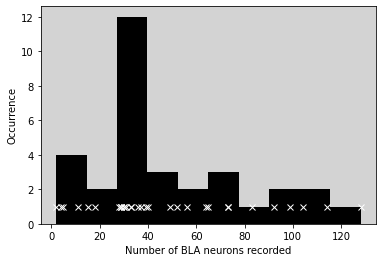

Active: 92.0 %
Inactive: 8.0 %


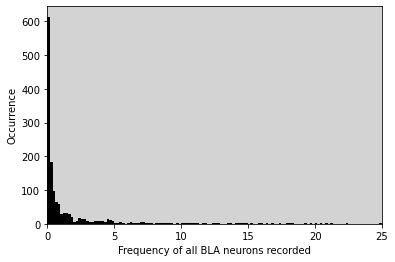

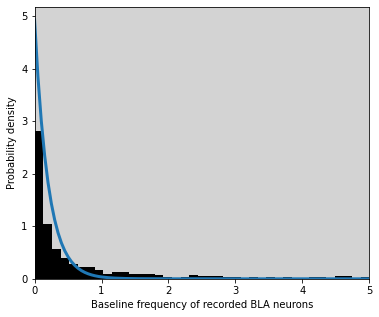

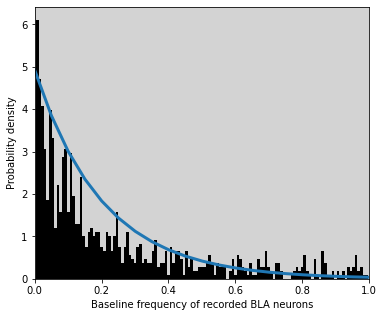

In [22]:
n_neurons_list = []

for i in range(n_neurons_mat.shape[0]):
    for j in range(n_neurons_mat.shape[1]):
        if ~np.isnan(n_neurons_mat[i,j]):
            n_neurons_list.append(int(n_neurons_mat[i,j]))

plt.figure()
ax = plt.axes()
ax.set_facecolor("lightgrey")
plt.plot(n_neurons_list, np.repeat(1, len(n_neurons_list)), 'x', color='white')
plt.hist(n_neurons_list, color='k')
plt.xlabel('Number of BLA neurons recorded')
plt.ylabel('Occurrence')
plt.show()

FR_list = []
for rat in range(FR_mat.shape[0]):
    for session in range(FR_mat.shape[1]):
        for neuron in range(FR_mat.shape[2]):
            if ~np.isnan(FR_mat[rat,session,neuron]) and FR_mat[rat,session,neuron] != 0:
                FR_list.append(FR_mat[rat,session,neuron])

overall_ratios = [len(np.where(np.array(FR_list)>=0)[0]), len(np.where(np.array(FR_mat)==0)[0])]

print("Active:",str(np.round(overall_ratios[0]/np.sum(overall_ratios)*100)),"%")
print("Inactive:",str(np.round(overall_ratios[1]/np.sum(overall_ratios)*100)),"%")


plt.figure()
ax = plt.axes()
ax.set_facecolor("lightgrey")
plt.hist(FR_list, color='k', bins=200)
plt.xlabel('Frequency of all BLA neurons recorded')
plt.ylabel('Occurrence')
plt.xlim([0,25])
plt.show()


plt.figure(figsize=([6,5]))
ax = plt.axes()
ax.set_facecolor("lightgrey")
plt.hist(FR_list, color='k', bins=300, density=True)
x = np.linspace(0, 25, 500)
plt.plot(x, 4.93 *np.exp(- 4.93 *x), linewidth=3)
plt.xlim([0,5])
plt.xlabel('Baseline frequency of recorded BLA neurons')
plt.ylabel('Probability density')

plt.show()

plt.figure(figsize=([6,5]))
ax = plt.axes()
ax.set_facecolor("lightgrey")
plt.hist(FR_list, color='k', bins=5000, density=True)
x = np.linspace(0, 25, 500)
plt.plot(x, 4.93 *np.exp(- 4.93 *x), linewidth=3)
plt.xlim([0,1])
plt.xlabel('Baseline frequency of recorded BLA neurons')
plt.ylabel('Probability density')

plt.show()

# Fit a line to describe distribution of firing rates

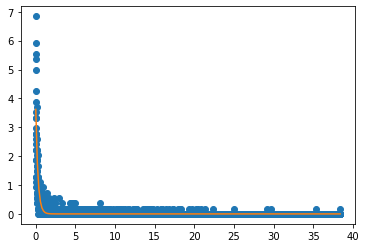

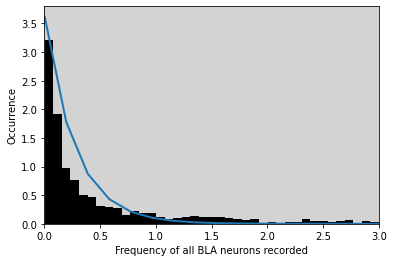

In [30]:
from scipy.optimize import curve_fit

# Find frequencies and bins of histogram
frequency_bins, bin_range = np.histogram(FR_list, bins=10000, density=True)[0], np.histogram(FR_list, bins=10000, density=True)[1]

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(lambda t, a: a * np.exp(-1*a * t), bin_range[:-1], frequency_bins)
a = popt[0]

xfit = np.linspace(bin_range[0], bin_range[-1], 200)

plt.plot(bin_range[:-1], frequency_bins, 'o')
plt.plot(xfit, a * np.exp(-1*a* xfit))

plt.figure()
ax = plt.axes()
ax.set_facecolor("lightgrey")
plt.hist(FR_list, color='k', bins=500, density=True)
plt.plot(xfit, a * np.exp(-1*a* xfit), linewidth=2)
plt.xlabel('Frequency of all BLA neurons recorded')
plt.ylabel('Occurrence')
plt.xlim([0,3])
plt.show()

In [31]:
print("Fitted line:", str(round(a, 2)),"*e^(-",str(round(a,2)),"*x)")

Fitted line: 3.68 *e^(- 3.68 *x)


# Compute p-values for stimulus-locked sequences

In [17]:
v = False

seq_window = 100 # in ms

# We construct a matrix for all p-values, with dimensions: [rat x session x  puff/safe]
p = np.full([4, 12, 2], np.nan)

rats = ['Rat08', 'Rat09', 'Rat10', 'Rat11']

puff_ = [True, False]

for irat, rat in enumerate(rats):
    print("Rat:", str(irat))
    # Load the (spike) data
    data = load_data(rat)
    spk = data.get_spk()
    
    
    for session_nr in session_matrix[irat]:
        if np.isnan(session_nr):
            continue
        print("    Session:", str(int(session_nr)))
        
        session_nr = int(session_nr)

        # Define neurons, session and times of the run
        neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

        # Define variables related to the location of the rats and airpuff events
        x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = v)

        # Construct the spike matrix 
        spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = v)   

        # For both puff and no puff 
        for ipuff in range(2):
            print("        ", str(puff_[ipuff]))
            # Mask the spike matrix to the events
            spk_matrix = mask_spikes(puff=puff_[ipuff])

            # Find p-value
            p_val = event_locked_seq(seq_window, n_surrogates, visualization = v)[1]
            print(p_val)

            p[irat,session_nr, ipuff] = p_val

Rat: 0
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
    Session: 0
         True


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan
         False
nan
    Session: 1
         True


C:\Users\pepij\AppData\Local\Temp\ipykernel_12508\2787300561.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_12508\2787300561.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


nan
         False
0.487
    Session: 2
         True
1.0
         False
nan
    Session: 3
         True
0.243
         False
nan
    Session: 4
         True
0.406
         False
0.804
    Session: 5
         True
0.254
         False
0.976
    Session: 6
         True
0.272
         False
0.93
    Session: 7
         True
0.336
         False
0.69
    Session: 8
         True
0.506
         False
0.659
Rat: 1
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

    Session: 0
         True


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.068
         False
0.223
    Session: 1
         True
nan
         False
1.0
    Session: 2
         True
0.216
         False
0.863
    Session: 3
         True
0.074
         False
0.105
    Session: 5
         True
0.173
         False
0.077
    Session: 6
         True
0.397
         False
0.463
    Session: 7
         True
0.539
         False
0.285
    Session: 8
         True
0.3
         False
0.785
    Session: 9
         True
nan
         False
0.732
Rat: 2
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:515: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat10\Rat10-20140704\Rat10-20140704-pos.csv
  self.__warning_msg(self.paths[rat][session]['position'])


    Session: 0
         True
nan
         False


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\pepij\AppData\Local\Temp\ipykernel_12508\2787300561.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_12508\2787300561.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


nan
    Session: 2
         True
0.491
         False
0.087
    Session: 3
         True
0.64
         False
0.83
    Session: 4
         True
nan
         False
0.498
    Session: 5
         True
1.0
         False
0.326
    Session: 6
         True
0.954
         False
0.027
    Session: 7
         True
nan
         False
0.872
    Session: 8
         True
nan
         False
nan
    Session: 9
         True
nan
         False
nan
Rat: 3
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
    Session: 0
         True


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.587
         False
0.065
    Session: 1
         True
0.326
         False
0.169
    Session: 2
         True
0.142
         False
0.063
    Session: 3
         True
0.009
         False
0.096
    Session: 4
         True
0.096
         False
0.513
    Session: 5
         True
0.993
         False
0.384
    Session: 6
         True
0.535
         False
0.331
    Session: 7
         True
0.653
         False
0.109


In [18]:
#p, win_range = result_p_puff_locked_2()

n_sessions = 12

significant_seq_puff = []

significant_seq_safe = []

for irat in range(p.shape[0]):
    for isession in range(p.shape[1]):
        p_puff = p[irat, isession, 0]
        p_safe = p[irat, isession, 1]
        if ~np.isnan(p_puff) and p_puff <= 0.05:
            significant_seq_puff.append([irat, isession, p_puff])
        if ~np.isnan(p_safe) and p_safe <= 0.05:
            significant_seq_safe.append([irat, isession, p_safe])

print("PUFF:")
for i in range(len(significant_seq_puff)):
    print("Rat:", significant_seq_puff[i][0])
    print("Session:", significant_seq_puff[i][1])
    print("P-val:", significant_seq_puff[i][2])
    print()

SAFE:
Rat: 2
Session: 6
P-val: 0.027

PUFF:
Rat: 3
Session: 3
P-val: 0.009



In [16]:
considered_sessions_puff = np.array([[3, 3]])                                 

# Construct sequence templates for puff events

In [67]:
def MI_decrease(ranks, neurons):
    """
    Calculates all the MIs after pruning each neuron individually.
    Input: 
    - ranks           : the ranks of all the trials
    - neurons         : a list of all neurons

    Output:
    - MIs_sorted      : all MIs after pruning, sorted
    - neurons_sorted  : all neurons, sorted on their MI after pruning
    """
    # Calculate MI before pruning
    baseline_MI = MI(firing_ranks2occ_matrix(ranks))
    
    MIs = np.zeros(len(neurons))
    
    # Prune each neuron individually from the original ranks and calculate MI
    for ineuron, neuron in enumerate(neurons):
        ranks_candidate, MI_candidate = cut_ranks(ranks, neuron)
        MIs[ineuron] = MI_candidate

    # Sort the MIs based on their decrease
    MIs_sorted = baseline_MI - np.sort(MIs)

    # Sort the neurons according to their decrease  (larger decreases resemble a higher likelihood to be part of the sequence)
    neurons_sorted = np.array(neurons)[np.argsort(MIs)]
    return MIs_sorted, neurons_sorted

def construct_sequence(ranks, n_neurons, n_surrogates, threshold=0.05, mode="max", max_neurons=10): 
"""
    Constructs the sequence, by filtering out insignificant neurons and subsequently ordering on either the mean or mode rank.
    Input:
    - ranks          :  the ranks of all the trials.
    - n_neurons      :  the total number of neurons in the data.
    - n_surrogates   :  the number of surrogates used for testing significance of individual neurons
    - threshold      :  value between 0 and 1. used for significance testing and can be interpreted as the p-value.
    - mode           :  either "mean" or "max". decides how the significant neurons are ordered to find sequence order.
    - max_neurons    :  the maximum sequence length. 

    Output:
    - sequence             :  a list containing the ordered sequence
    """

    # Find MIs with the largest decrease after pruning the neurons individually
    MIs, seq_neurons = MI_decrease(ranks, range(n_neurons))
    MIs = MIs[:max_neurons]
    seq_neurons = seq_neurons[:max_neurons]
    
    MIs_surrogate = np.zeros([n_surrogates, max_neurons])

    # Keep track of total number of surrogates that have a larger MI decrease after pruning the x'th most significant neuron
    for s in range(n_surrogates):
        for ineuron in range(max_neurons):
            #print(seq_neurons[ineuron])
            surrogate = surrogate_ranks(ranks, seq_neurons[ineuron])
            occ = firing_ranks2occ_matrix(surrogate)
            #plt.figure()
            #plt.imshow(sort_occ_matrix(occ)[0], aspect='auto')
            #plt.yticks(range(sort_occ_matrix(occ)[0].shape[0]), sort_occ_matrix(occ)[2][sort_occ_matrix(occ)[1]])
            #plt.show()

            MIs_surrogate[s, ineuron] = MI(firing_ranks2occ_matrix(surrogate)) - cut_ranks(surrogate, seq_neurons[ineuron])[1]

    insignificant = np.array([np.count_nonzero(MIs_surrogate[:,ineuron]>=MIs[ineuron])/n_surrogates > threshold for ineuron in range(max_neurons)], dtype=int)
    ratios = [np.count_nonzero(MIs_surrogate[:,ineuron]>=MIs[ineuron])/n_surrogates for ineuron in range(max_neurons)]
    
    if len(np.where(insignificant==0)[0])>0:
        seq_neurons = seq_neurons[np.where(insignificant==0)[0]]
    else:
        seq_neurons = seq_neurons[:3]
    
    
    occ_matrix = firing_ranks2occ_matrix(ranks)
    
    # Compute mean and maximum ranks
    mean_ranks = np.zeros(len(seq_neurons))
    max_ranks = np.zeros(len(seq_neurons))
    for ineuron, neuron in enumerate(seq_neurons):        
        mean_ranks[ineuron] = np.mean(occ_matrix[neuron,:]*np.arange(occ_matrix.shape[1]))
        max_ranks[ineuron] = np.argmax(occ_matrix[neuron,:])

    # Sort the sequence neurons
    if mode == "mean":
        sequence = np.array(seq_neurons)[np.argsort(mean_ranks)]
    else: 
        sequence = np.array(seq_neurons)[np.argsort(max_ranks)]

    # Create the template
    template = np.zeros([occ_matrix.shape[0], occ_matrix.shape[0]])

    for rank, neuron in enumerate(sequence):
        template[neuron, rank] = 1

    # Create the null-template
    null_template = np.zeros([occ_matrix.shape[0], occ_matrix.shape[0]])
    null_template[sequence,:len(sequence)] = 1/len(sequence)

    return sequence, template, null_template, MIs, MIs_surrogate, ratios

def cut_ranks(ranks, neuron):
    """
    Cuts all entries of the neuron out of the ranks. Also, the MI after cutting is outputted.
    """
    pruned_ranks = np.zeros([ranks.shape[0], ranks.shape[1]])
    for itrial in range(ranks.shape[0]):
        trial = list(ranks[itrial])
        if neuron in trial:
            trial.remove(neuron)
            trial.append(np.nan)
        pruned_ranks[itrial] = trial    
    return pruned_ranks, MI(firing_ranks2occ_matrix(pruned_ranks))

def surrogate_ranks(firing_ranks, neuron): 
    """
    Surrogate ranks are created by randomly shuffling the ranks of all spikes of the given neuron. 
    The sequential information of all other neurons remain untouched.
    """
    ranks = np.zeros([firing_ranks.shape[0], firing_ranks.shape[1]])
    
    for itrial, trial in enumerate(firing_ranks):
        if np.any(trial==neuron):
            trial_list = list(trial)
            spike_indices = np.sort(np.where(trial==neuron)[0],)[::-1]
            
            for spike_idx in spike_indices:
                trial_list.pop(spike_idx)      
            for spk in range(len(spike_indices)):
                ivalid = np.where(~np.isnan(trial))[0]
                n_slots = len(ivalid)+1
                new_rank = np.random.randint(n_slots)
                trial_list.insert(new_rank, neuron)
            ranks[itrial,:] = np.array(trial_list)
        else:
            ranks[itrial,:] = firing_ranks[itrial]
    return ranks
    

In [23]:
n_surrogates = 100

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


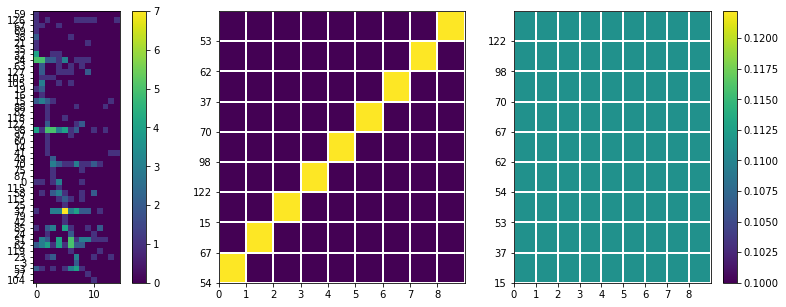

In [27]:
figlabels = ['Figure10.svg', 'Figure11.svg']
figlabels_2 = ['Figure10.jpg', 'Figure11.jpg']

rat_id = 3
rat = rats[rat_id]
session_nr = 3
seq_window = 95
window = (-500,500)

# Load the (spike) data
data = load_data(rat)
spk = data.get_spk()

# Define neurons, session and times of the run
neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

# Define variables related to the location of the rats and airpuff events
x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = False)

# Construct the spike matrix 
spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = False)   

# Mask the spike matrix to the events
spk_matrix = mask_spikes()

# Find the ranks, OCC matrix and URI
ranks = firing_ranks_spkmatrix(spk_matrix[:,:,window[1]:window[1]+seq_window])    
occurrence_matrix = firing_ranks2occ_matrix(ranks)

URI = MI(occurrence_matrix)
sorted_occ = sort_occ_matrix(occurrence_matrix)

sequence, template, null_template, MIs, MIs_surrogate, ratios  = construct_sequence(ranks, n_neurons, n_surrogates, threshold=0.05, mode="max", max_neurons=30)
sorted_template = sort_occ_matrix(template)
sorted_null = sort_occ_matrix(null_template)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(sorted_occ[0])
plt.yticks(range(len(sorted_occ[2])), sorted_occ[2][sorted_occ[1]])
plt.colorbar()
plt.subplot(1, 3, 2)
plt.pcolormesh(sorted_template[0], edgecolors='w', linewidth=2)
plt.xticks(range(sorted_template[0].shape[1]))
plt.yticks(range(sorted_template[0].shape[0]), sorted_template[2][sorted_template[1]])
plt.subplot(1, 3, 3)
#plt.imshow(sorted_null[0])
plt.xticks(range(sorted_null[0].shape[1]))
plt.yticks(range(sorted_null[0].shape[0]), sorted_null[2][sorted_null[1]])
plt.pcolormesh(sorted_null[0], edgecolors='w', linewidth=2)
plt.colorbar()
#plt.savefig(figlabels[i])
#plt.savefig(figlabels_2[i])
plt.show()

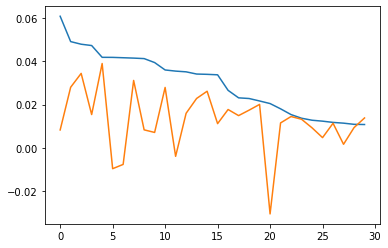

In [28]:
plt.plot(MIs)
plt.plot(np.mean(MIs_surrogate, axis=0))

In [16]:
rat_id = 3
rat = rats[rat_id]
session_nr = 3
window = (-1200,1200)

# Load the (spike) data
data = load_data(rat)
spk = data.get_spk()

# Define neurons, session and times of the run
neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

# Define variables related to the location of the rats and airpuff events
x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = False)

# Construct the spike matrix 
spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = False)   

# Mask the spike matrix to the events
spk_matrix = mask_spikes()

# Find the ranks, OCC matrix and URI
ranks = firing_ranks_spkmatrix(spk_matrix[:,:,window[1]:window[1]+seq_window])    
occurrence_matrix = firing_ranks2occ_matrix(ranks)

# Make matrices of shape [puff/safe x timebin]
template_corr = np.zeros([2,spk_matrix_.shape[2]-seq_window])
null_template_corr = np.zeros([2,spk_matrix_.shape[2]-seq_window])

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [20]:
sequence = np.array([54, 67, 15, 122, 98, 70, 37, 62, 53])

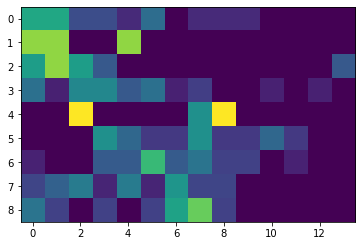

In [21]:
occurrence_matrix_filtered = np.zeros([occurrence_matrix.shape[0], occurrence_matrix.shape[1]])

for seq_neur in sequence:
    occurrence_matrix_filtered[seq_neur] = occurrence_matrix[seq_neur]/np.sum(occurrence_matrix[seq_neur])

plt.imshow(sort_occ_matrix(occurrence_matrix_filtered)[0])

In [25]:
# Create the null-template
null_template = np.zeros([occurrence_matrix.shape[0], occurrence_matrix.shape[0]])
active_ranks = sort_occ_matrix(occurrence_matrix_filtered)[0].shape[1]
null_template[sequence,:active_ranks] = 1/active_ranks

In [26]:
for i, puff_boolean in enumerate([True, False]):
    # Construct the spike matrix 
    spk_matrix = mask_spikes(puff=puff_boolean)
    for t in range(spk_matrix.shape[2]-seq_window):
        # Find the ranks, OCC matrix and URI
        ranks = firing_ranks_spkmatrix(spk_matrix[:,:,t:t+seq_window])    
        occurrence_matrix = firing_ranks2occ_matrix(ranks)
        template_corr[i,t] = np.dot(occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
        null_template_corr[i,t] = np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))

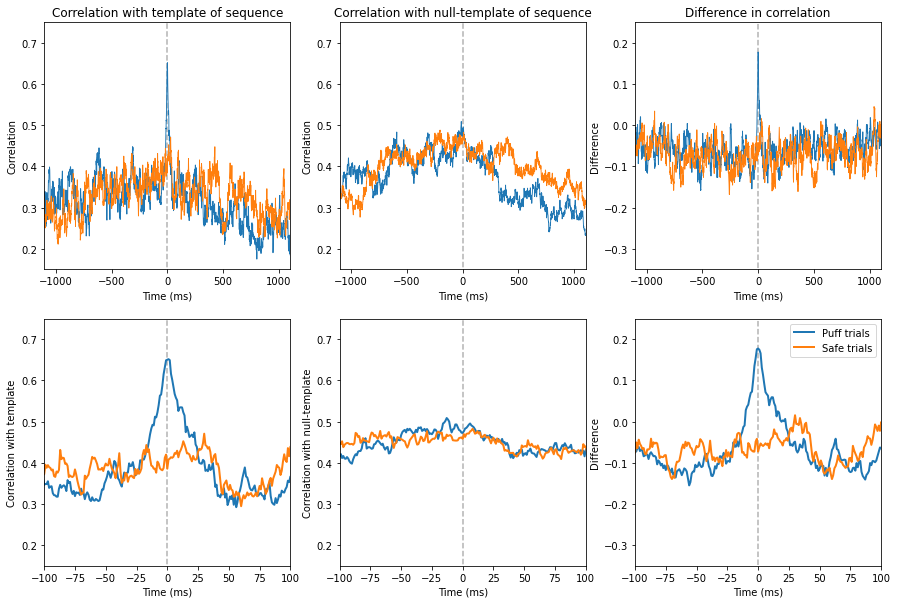

In [27]:
lw = 0.9
lw2 = 2

ylims=(0.15,0.75)
ylims_diff=(-0.35,0.25)

plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plt.title('Correlation with template of sequence')
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], template_corr[0], lw=lw, label='Puff trials')
plt.vlines(x = 0, ymin = -10, ymax=ylims[1], color='k', linestyle='--', alpha=0.3)
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], template_corr[1], lw=lw, label='Safe trials')
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.ylim(ylims)
plt.xlim(-1200+95, 1200-95)
plt.margins(x=0)
plt.margins(y=0)

plt.subplot(2, 3, 2)
plt.title('Correlation with null-template of sequence')
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], null_template_corr[0],lw=lw, label='Puff trials')
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], null_template_corr[1],lw=lw, label='Safe trials')
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.ylim(ylims)
plt.vlines(x = 0, ymin = -10, ymax=ylims[1], color='k', linestyle='--', alpha=0.3)
plt.xlim(-1200+95, 1200-95)
plt.margins(x=0)
plt.margins(y=0)


plt.subplot(2, 3, 3)
plt.title('Difference in correlation')
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], template_corr[0]-null_template_corr[0],lw=lw, label='Puff trials')
plt.vlines(x = 0, ymin =-10, ymax=ylims[1], color='k', linestyle='--', alpha=0.3)
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], template_corr[1]-null_template_corr[1],lw=lw, label='Safe trials')
plt.xlabel('Time (ms)')
plt.ylabel('Difference')
plt.margins(x=0)
plt.margins(y=0)
plt.xlim(-1200+95, 1200-95)
plt.ylim(ylims_diff)


plt.subplot(2, 3, 4)
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], template_corr[0], lw=lw2, label='Puff trials')
plt.vlines(x = 0, ymin = -10, ymax=ylims[1], color='k', linestyle='--', alpha=0.3)
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], template_corr[1], lw=lw2, label='Safe trials')
plt.xlabel('Time (ms)')
plt.ylabel('Correlation with template')
plt.ylim(ylims)
plt.margins(x=0)
plt.margins(y=0)
plt.xlim([-100, 100])


plt.subplot(2, 3, 5)
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], null_template_corr[0],lw=lw2, label='Puff trials')
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], null_template_corr[1],lw=lw2, label='Safe trials')
plt.xlabel('Time (ms)')
plt.ylabel('Correlation with null-template')
plt.ylim(ylims)
plt.vlines(x = 0, ymin = -10, ymax=ylims[1], color='k', linestyle='--', alpha=0.3)
plt.margins(x=0)
plt.margins(y=0)
plt.xlim([-100, 100])


plt.subplot(2, 3, 6)
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], template_corr[0]-null_template_corr[0],lw=lw2, label='Puff trials')
plt.vlines(x = 0, ymin =-10, ymax=ylims[1], color='k', linestyle='--', alpha=0.3)
plt.plot(np.array(range(spk_matrix.shape[2]-seq_window))-window[1], template_corr[1]-null_template_corr[1],lw=lw2, label='Safe trials')
plt.xlabel('Time (ms)')
plt.ylabel('Difference')
plt.margins(x=0)
plt.margins(y=0)
plt.ylim(ylims_diff)
plt.xlim([-100, 100])
plt.legend()


plt.savefig('Figure12.svg')
plt.savefig('Figure12.png')

plt.show()


In [28]:
rat_id = 3
rat = rats[rat_id]
session_nr = 3
seq_window = 95
window = (-200,200)

# Load the (spike) data
data = load_data(rat)
spk = data.get_spk()

# Define neurons, session and times of the run
neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

# Define variables related to the location of the rats and airpuff events
x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = False)

# Construct the spike matrix 
spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = False)   

# Mask the spike matrix to the events
spk_matrix = mask_spikes()

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


In [32]:
trial_corr = np.zeros([len(mask_spikes())])
trial_corr_safe = np.zeros([len(mask_spikes(puff=False))])

spk_matrix = mask_spikes()
for itrial_slice, trial_slice in enumerate(spk_matrix):
    spk_matrix_slice = np.zeros([2, trial_slice.shape[0], trial_slice.shape[1]])
    spk_matrix_slice[0] = trial_slice
    ranks = firing_ranks_spkmatrix(spk_matrix_slice[:,:,200:200+seq_window])    
    occurrence_matrix = firing_ranks2occ_matrix(ranks)
    trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))

spk_matrix = mask_spikes(puff=False)
for itrial_slice, trial_slice in enumerate(spk_matrix):
    spk_matrix_slice = np.zeros([2, trial_slice.shape[0], trial_slice.shape[1]])
    spk_matrix_slice[0] = trial_slice
    ranks = firing_ranks_spkmatrix(spk_matrix_slice[:,:,200:200+seq_window])    
    occurrence_matrix = firing_ranks2occ_matrix(ranks)
    trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))

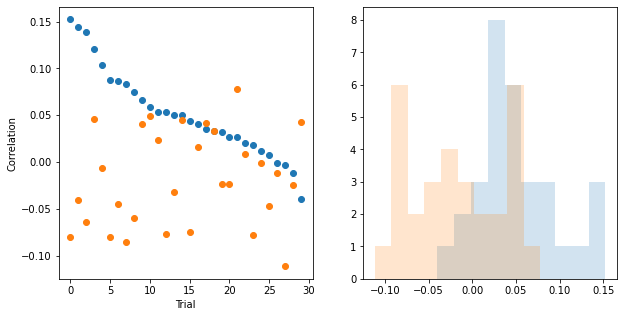

In [33]:
width=0
spk_matrix = mask_spikes()
ind = np.arange(len(spk_matrix)-1)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(ind,np.sort(trial_corr[:len(trial_corr)-1])[::-1])
spk_matrix = mask_spikes(puff=False)
plt.scatter(ind,trial_corr_safe[np.argsort(trial_corr[:len(trial_corr)-1])][::-1])
#plt.ylim([0,1])
plt.xlabel('Trial')
plt.ylabel('Correlation')

plt.subplot(1, 2, 2)

plt.hist(trial_corr, bins=10, alpha=0.2)
plt.hist(trial_corr_safe, bins=10, alpha=0.2)
#plt.savefig('Figure15.svg')
#plt.savefig('Figure15.jpg')
plt.show()

In [36]:
from scipy.stats import spearmanr as spearmanr

In [39]:
spearmanr(trial_corr[:len(trial_corr)-1], trial_corr_safe)

SignificanceResult(statistic=-0.16307007786429364, pvalue=0.3892359903991873)

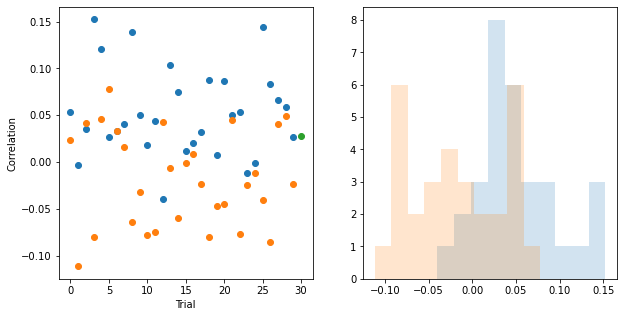

In [34]:
width=0
spk_matrix = mask_spikes()
ind = np.arange(len(spk_matrix)-1)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(ind,trial_corr[:len(trial_corr)-1])
spk_matrix = mask_spikes(puff=False)
plt.scatter(ind,trial_corr_safe)
plt.scatter(len(spk_matrix), trial_corr[-1])
#plt.ylim([0,1])
plt.xlabel('Trial')
plt.ylabel('Correlation')

plt.subplot(1, 2, 2)

plt.hist(trial_corr, bins=10, alpha=0.2)
plt.hist(trial_corr_safe, bins=10, alpha=0.2)
plt.savefig('Figure14.svg')
plt.savefig('Figure14.jpg')
plt.show()